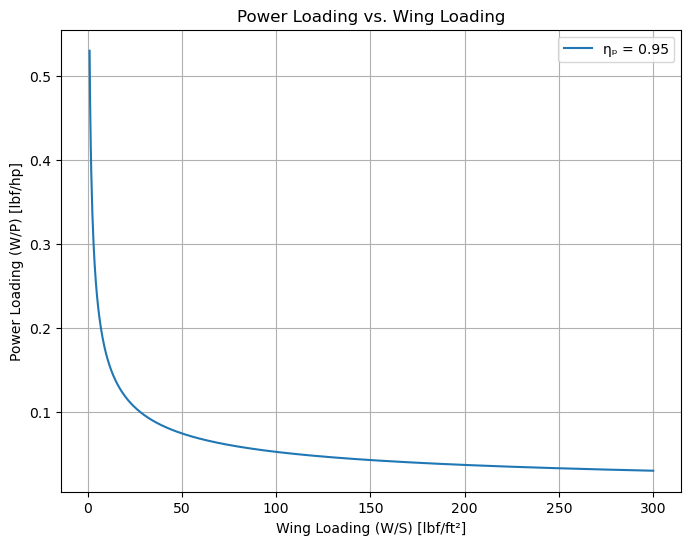

In [2]:
# Metabook pg. 98
# Using A3 for constants

import numpy as math
import matplotlib.pyplot as plt

#m_dot = float(input("Enter the mass flow rate of air going through the stream tube (slug/s): "))
#v_jet = float(input("Enter the velocity of air being ejected (ft/s): "))
#v_inf = float(input("Enter the aircraft flying speed (ft/s): "))

# Constants
rho = 0.002377  # Air density (slug/ft^3) at sea level
V = 250 * 1.688
v_cruise = V * 0.5
v_inf = v_cruise

AR = 28/3 # NEED TO UPDATE FOR DESIGN 3 ####

W_0 = 6354 # Design 3
S_ref = 336 
c = 1.0447 # Source - Gama
d = 0.5326 # Source - Gama
S_wet = (10 ** c) * (W_0 ** d)

S_wet_S_ref =  S_wet / S_ref
c_f = 0.0055 

parasite_drag_coeff = c_f * S_wet_S_ref

eff_clean = 0.825

cL_max_cruise = 1.6 
cD_max_cruise = parasite_drag_coeff + (1 / (math.pi * eff_clean * AR)) * (cL_max_cruise ** 2)


#CL = 1.0        # Typical cruise lift coefficient
#CD = 0.02       # Typical cruise drag coefficient

# Efficiency values to compare
#eta_p_values = [0.75, 0.85, 0.95]

eta_p = 0.95

# Wing loading range (W/S) in lbf/ft^2
WS_range = math.linspace(1, 300, 1000)

# Plot W/P vs. W/S
plt.figure(figsize=(8,6))
#for eta_p in eta_p_values:
WP = eta_p * (cL_max_cruise/cD_max_cruise) * math.sqrt((rho * cL_max_cruise) / (2 * WS_range))
plt.plot(WS_range, WP, label=f'ηₚ = {eta_p:.2f}')

# Labels and legend
plt.xlabel("Wing Loading (W/S) [lbf/ft²]")
plt.ylabel("Power Loading (W/P) [lbf/hp]")
plt.title("Power Loading vs. Wing Loading")
plt.legend()
plt.grid(True)
plt.show()


#thurst = m_dot * (v_jet - v_inf)

#power_available = thurst * v_inf

#eta_p1 = power_available / (power_available + (0.5 * m_dot * (v_jet - v_inf)**2))
#eta_p2 = 2 / (1 + (v_jet / v_inf))



